HighTime - Web traffic analysis neural model
=============
<span style="color: lightsteelblue;">Deep Learning</span>

The goal of this assignment is to train a simple DNN model to make predictions over web traffic.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import matplotlib.pyplot as plt

Let us mimic real traffic data by using normal distribution:

[  5  17  43  69  83 137 164 283 376 414 453 498 486 433 405 308 276 200]


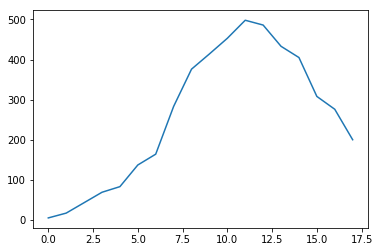

In [2]:
def fake_train(batch_size=24):
  assert batch_size > 0 and batch_size < 25
  normal = np.random.normal(12, 4, 5000)
  train = np.arange(batch_size)

  for i in range(0, batch_size):
    count = 0
    for p in normal:
      if (p >= i and p < i + 1):
        count += 1
    train[i] = count
  return train

example = fake_train(18)
print(example)

plt.plot(range(0, 18), example)
plt.show()

Function to generate a training batch:

In [3]:
def secs_to_time(time_in_seconds):
  hours = time_in_seconds // 3600
  minutes = (time_in_seconds - hours * 3600) // 60
  seconds = time_in_seconds - hours * 3600 - minutes * 60
  return hours, minutes, seconds

def time_to_secs(hour, minutes, seconds):
  return hour * 3600 + minutes * 60 + seconds

def secs_to_string(sec):
  result = ':'.join([('%d' % i) for i in secs_to_time(sec)])
  return result + (' (%dth second)' % sec)

class BatchGenerator(object):
  def __init__(self, batch_size):
    self._batch_size = batch_size

  def spit(self):
    labels = fake_train(self._batch_size).reshape(self._batch_size, 1)
    train = []

    for hour in range(self._batch_size):
      minutes = random.randint(0, 59)
      seconds = random.randint(0, 59)
      train.append(time_to_secs(hour, minutes, seconds))

    return np.array(train, dtype=np.float32).reshape(self._batch_size, 1), labels

Generate valid and test datasets:

In [4]:
generator = BatchGenerator(24)

test_dataset, test_labels = generator.spit()

print(test_dataset)
print(test_labels)

for sec, label in list(zip(test_dataset, test_labels)):
  print('Time %s => %d rps' % (secs_to_string(sec), label))

[[  1612.]
 [  5556.]
 [  8026.]
 [ 13976.]
 [ 14581.]
 [ 18236.]
 [ 22527.]
 [ 27948.]
 [ 32383.]
 [ 33960.]
 [ 38647.]
 [ 42985.]
 [ 45782.]
 [ 48388.]
 [ 52879.]
 [ 57290.]
 [ 59158.]
 [ 61562.]
 [ 66156.]
 [ 68633.]
 [ 74289.]
 [ 76366.]
 [ 80282.]
 [ 85324.]]
[[  9]
 [ 15]
 [ 26]
 [ 57]
 [ 84]
 [128]
 [193]
 [250]
 [340]
 [425]
 [472]
 [484]
 [533]
 [468]
 [404]
 [344]
 [248]
 [196]
 [111]
 [ 95]
 [ 54]
 [ 31]
 [ 14]
 [  7]]
Time 0:26:52 (1612th second) => 9 rps
Time 1:32:36 (5556th second) => 15 rps
Time 2:13:46 (8026th second) => 26 rps
Time 3:52:56 (13976th second) => 57 rps
Time 4:3:1 (14581th second) => 84 rps
Time 5:3:56 (18236th second) => 128 rps
Time 6:15:27 (22527th second) => 193 rps
Time 7:45:48 (27948th second) => 250 rps
Time 8:59:43 (32383th second) => 340 rps
Time 9:26:0 (33960th second) => 425 rps
Time 10:44:7 (38647th second) => 472 rps
Time 11:56:25 (42985th second) => 484 rps
Time 12:43:2 (45782th second) => 533 rps
Time 13:26:28 (48388th second) => 468 rps
Tim

Simple NN Model with one hidden layer and hyperbolic tangent activation function.

In [9]:
feature_size = 1 # number of features to feed input
num_labels = 1 # number of output labels
num_hidden_nodes = 4
batch_size = 17
learning_rate = 0.005

graph = tf.Graph()
with graph.as_default():
  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  X = tf.placeholder(tf.float32, shape=(batch_size, feature_size))
  Y = tf.placeholder(tf.float32, shape=(batch_size, 1))

  tf_test_dataset = tf.constant(test_dataset)
  predict_data = tf.placeholder(tf.float32, shape=(1, feature_size))

  # Hidden layer variables
  weights1 = tf.Variable(tf.truncated_normal([feature_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))

  # Variables.
  weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  hidden_layer = tf.nn.sigmoid(tf.matmul(X, weights1) + biases1)

  y = tf.matmul(hidden_layer, weights2) + biases2
  loss = tf.reduce_mean(tf.square(y - Y))

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

  # Predictions for the training, test and real data.
  train_prediction = y
#   test_prediction_hidden = tf.nn.sigmoid(tf.matmul(tf_test_dataset, weights1) + biases1)
#   test_prediction = tf.matmul(test_prediction_hidden, weights2) + biases2
  prediction_hidden = tf.nn.sigmoid(tf.matmul(predict_data, weights1) + biases1)
  prediction = tf.matmul(prediction_hidden, weights2) + biases2

In [10]:
num_steps = 551
generator = BatchGenerator(batch_size)

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels))
          / predictions.shape[0])

session = tf.Session(graph=graph)

with graph.as_default():
  with session.as_default():
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
      batch_data, batch_labels = generator.spit()
#       print(batch_data.shape, batch_labels.shape)
      # Prepare a dictionary telling the session where to feed the minibatch.
      # The key of the dictionary is the placeholder node of the graph to be fed,
      # and the value is the numpy array to feed to it.
      feed_dict = {X : batch_data, Y : batch_labels}
      _, l = session.run(
        [optimizer, loss], feed_dict=feed_dict)
      if (step % 50 == 0):
        print("Minibatch loss at step %d: %f" % (step, l))
#         print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
  #       print("Validation accuracy: %.1f%%" % accuracy(
  #         valid_prediction.eval(), valid_labels))
#         print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 101879.945312
Minibatch loss at step 50: 33723.062500
Minibatch loss at step 100: 28679.201172
Minibatch loss at step 150: 29763.468750
Minibatch loss at step 200: 30679.763672
Minibatch loss at step 250: 30639.957031
Minibatch loss at step 300: 32010.757812
Minibatch loss at step 350: 28941.101562
Minibatch loss at step 400: 29980.830078
Minibatch loss at step 450: 31324.445312
Minibatch loss at step 500: 28850.371094
Minibatch loss at step 550: 30723.386719


Let us check it out

In [13]:
to_predict = time_to_secs(1, 0, 0)
print('We want to predict rps at %s' % secs_to_string(to_predict))
data_to_predict = np.array([to_predict]).reshape(1, feature_size)

with session.as_default():
  print(prediction.eval(feed_dict={predict_data : data_to_predict}))
  print(weights1.eval())
  print(biases1.eval())

We want to predict rps at 1:0:0 (3600th second)
[[ 262.34436035]]
[[ 1.26372385 -1.40144181  0.53504199 -0.91464972]]
[  0.00000000e+00   5.64513605e-13  -8.24061339e-04  -3.00552205e-09]
